In [6]:
import pandas as pd
import geopandas as gpd
import os
from ts_preprocesing import *

### Reading SAR mode process from Karina and comparing with LRM mode process from ALTIS with Silvain
#### In this script:
#### 1. Get data from SAR procesing original observations
#### 2. Sumarize data by time account for number of observations
#### 3. Link data with Altis current observations and ground observations
#### 4. Plot a) WSE from SAR and LRM modes b) # obs in SAR and LRM mode c) WSE change for both modes d) WSE change from SAR against WSE change from LRM


In [7]:
#Read observations from SAR procesing mode 

#Original altimeter
path_to_alt='/home/angelica/Documents/py_linux/pylocss/data/karina/ourlakes/tmb_lakes/'

#Modeled reconstructed time series
path_to_ts="/home/angelica/Documents/py_linux/pylocss/data/karina/ourlakes/ts_lakes/"

# Lake shapefile
path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'
df_sel_lakes=gpd.read_file(path_lakes, encoding='utf-8')


In [8]:
#Get ground observations and LRM procesing mode in the current lake buffer (around 3 km outside the lake boundaries)
time_fig='20230912_10_39'
df_final_altis=pd.read_csv('../data/results/preprossed_altis_data_'+time_fig+'.csv', sep=',',low_memory=False, parse_dates=['date'])

In [11]:
#read data from Karinas results SAR mode original nadir altimeter observations

df_files=pd.DataFrame()
sep=' '

for folder in os.listdir(path_to_alt):
        path=path_to_alt+folder+'/'
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))&(f.endswith('ocog.dat'))]
        for f in files:
            f_name=path+f
            df_file=pd.read_csv(f_name, sep=sep)
            df_file['sat']=f[:3]
            df_file['orbit']=f[4:7]
            df_file['lake_id']=folder
            df_files=pd.concat([df_files, df_file], axis=0)
df_files=pd.merge(df_files,df_sel_lakes, on='lake_id', how='inner') 
list_lakes=df_files['lake_id'].unique()
list_lakes

array(['19069', '7320414542', '4530720592', '12030', '1052515', '12327',
       '7320415112', '12036', '6610149612', '7421066862', '7830177462',
       '7320428982', '7320417422', '21', '6530064712', '7320103213',
       '19060', '6610142963', '19126', '7820034152', '22', '12056',
       '1052865', '865120', '6620000613'], dtype=object)

In [12]:
#for each lake in locss lakes list_lakes
# get the same orbit in both
# get the same time in both
#plot
df_lake_final=pd.DataFrame()
for lake in list_lakes:
    df_lake=df_final_altis.loc[df_final_altis['lake_id']==int(lake)]
    orbits=df_lake['orbit'].unique()
    
    for ob in orbits:
        df_lake_k=df_files.loc[(pd.to_numeric(df_files['orbit'])==ob)&(df_files['lake_id']==lake)]
        
        if not df_lake_k.empty:
            print(ob, lake)
            # print(df_lake_k)
            #rename columns in karinas file so it's not the same
            df_lake_k.columns=[i+'_k' for i in df_lake_k.columns]
            
            df_lake_s=df_lake.loc[df_lake['orbit']==ob]
            df_lake_s=df_lake_s.round({'decimal_y':3})
            group_by_fd=['time_k']
            sum_dict={'height_k':['median','count', 'std'],
                      'sat_k':'first',
                      'orbit_k':'first',
                      'lake_id_k':'first',
                      'gauge_id_k':'first',
                      'lake_name_k':'first'}
            df_lake_k_gb=aggregage_values_by_group(df_lake_k, group_by_fd, sum_dict)
            
            #merge here 
            df_lake_merged=pd.merge(df_lake_k_gb, df_lake_s, left_on=['time_k'], right_on=['decimal_y'], how='inner')
            df_lake_final=pd.concat([df_lake_final,df_lake_merged],axis=0)


95 19069
261 4530720592
52 12030
311 1052515
380 12327
11 7320415112
223 12036
338 6610149612
311 7421066862
13 7830177462
318 21
10 6530064712
97 7320103213
38 19060
281 6610142963
280 19126
223 12056


In [21]:
#plot SAR mode and LMR mode
df=df_lake_final.copy()
df=df.rename(columns={'height_k_median':'SAR_mode_median','height':'LRM_mode_median', 'height_k_count':'nobs_SAR', 'nobs_altis':'nobs_LRM'})
df['SAR_mean_dev']=df['SAR_mode_median']-df['SAR_mode_median'].mean()
df['LRM_mean_dev']=df['LRM_mode_median']-df['LRM_mode_median'].mean()

id_vars=['time_k', 'orbit_k_first', 'lake_id_k_first', 'lake_name_k_first']
id_values=['SAR_mode_median', 'nobs_SAR', 'LRM_mode_median',	'nobs_LRM','val_cd_d_5', 'SAR_mean_dev', 'LRM_mean_dev']
var_name='WSE_vars'
df_melt=pd.melt(df, id_vars=id_vars, value_vars=id_values, var_name=var_name)
df_lakes_final_joined=df.copy()


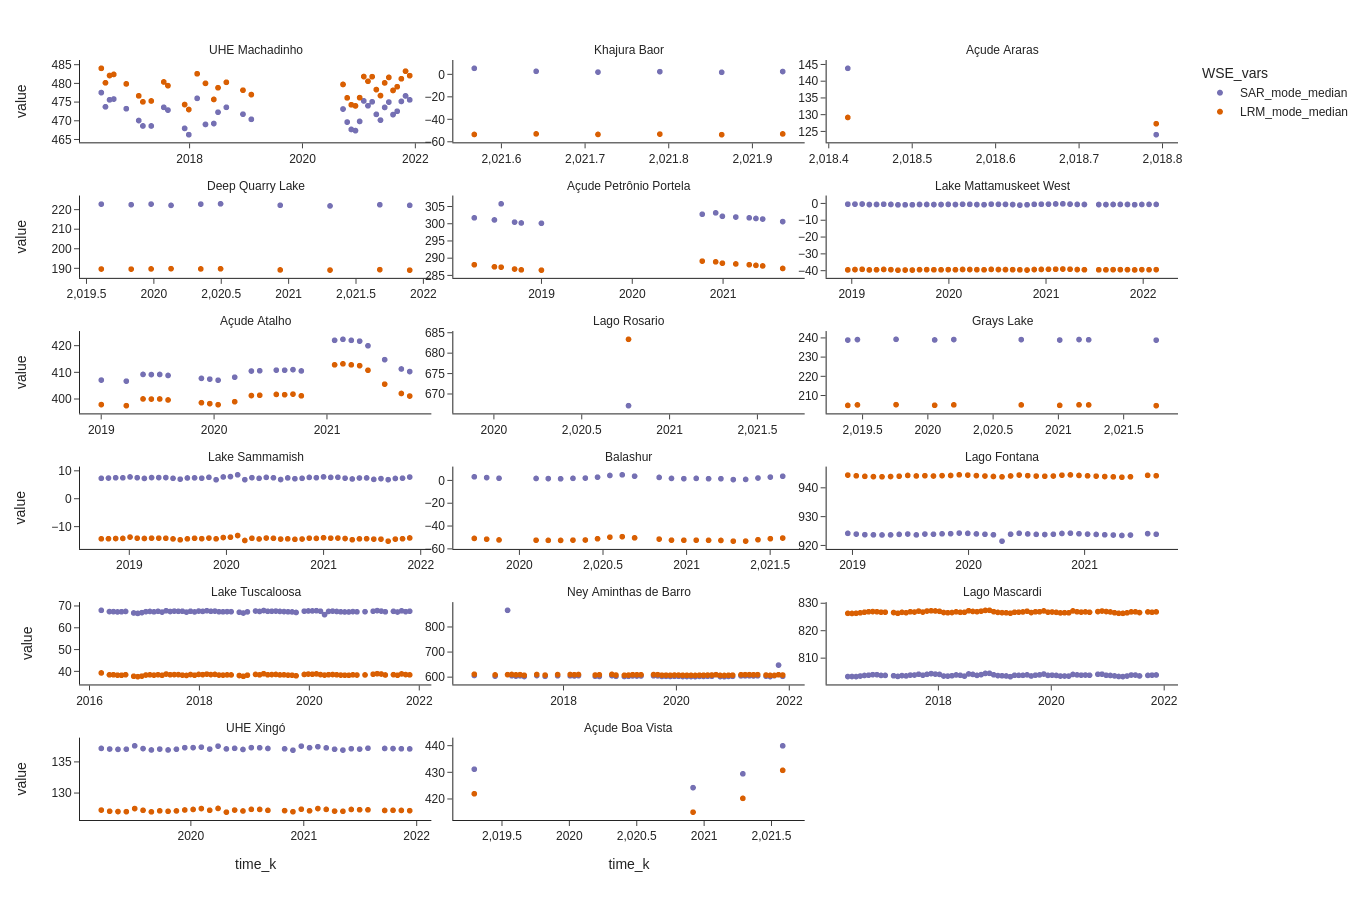

In [20]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df=df_melt
x_fd='time_k'
y_fd='value'
facet='lake_name_k_first'
color='WSE_vars'
fig = px.scatter(df.loc[df['WSE_vars'].isin(['SAR_mode_median','LRM_mode_median'])], x=x_fd, y=y_fd, 
                 facet_col=facet,color=color,facet_col_wrap=3,
                 color_discrete_sequence=["#7570b3","#d95f02"],
                 template="simple_white", width=1200, height=900)
# fig.update_traces(marker=dict(size=5,color='#661666'))
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_yaxis(lambda y: y.update(showticklabels=True,matches=None))
fig.for_each_xaxis(lambda x: x.update(showticklabels=True,matches=None))

fig.show()
del df


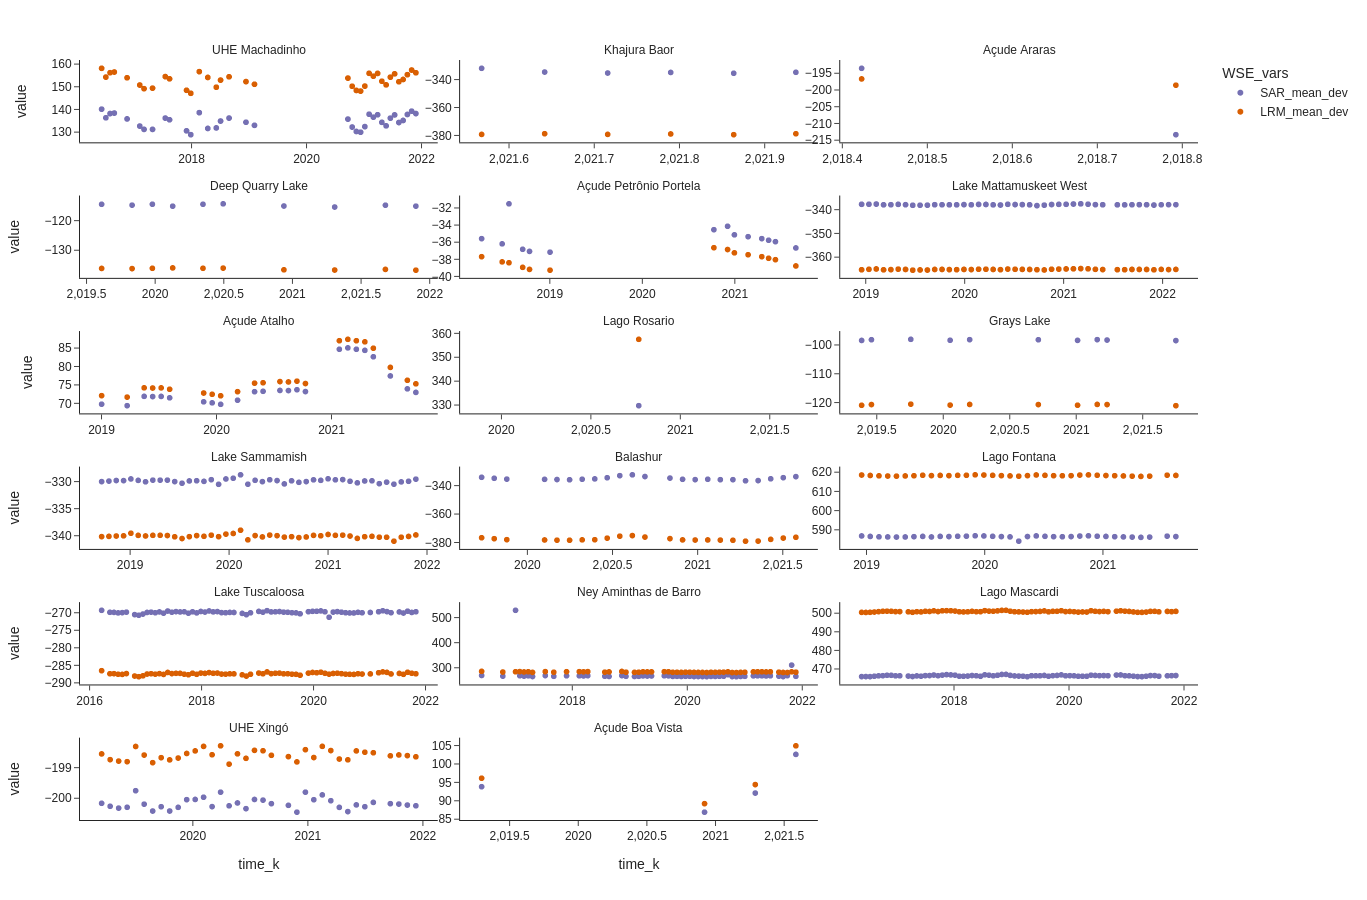

In [22]:

df=df_melt
x_fd='time_k'
y_fd='value'
facet='lake_name_k_first'
color='WSE_vars'
fig = px.scatter(df.loc[df['WSE_vars'].isin(['SAR_mean_dev','LRM_mean_dev'])], x=x_fd, y=y_fd, 
                 facet_col=facet,color=color,facet_col_wrap=3,
                 color_discrete_sequence=["#7570b3","#d95f02"],
                 template="simple_white", width=1200, height=900)
# fig.update_traces(marker=dict(size=5,color='#661666'))
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_yaxis(lambda y: y.update(showticklabels=True,matches=None))
fig.for_each_xaxis(lambda x: x.update(showticklabels=True,matches=None))
fig.show()
del df


# df=df_melt
# x_fd='time_k'
# y_fd='value'
# facet='lake_name_k_first'
# color='height_count'
# fig = px.bar(df.loc[df['height_count'].isin(['height_k_count','nobs_altis'])], x=x_fd, y=y_fd, 
#                  facet_col=facet,color=color,facet_col_wrap=3, barmode='group',
#                  template="simple_white", width=1200, height=900)
# # fig.update_traces(marker=dict(size=5,color='#661666'))
# fig.update_xaxes(matches=None)
# fig.update_yaxes(matches=None)

# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.show()
# del df

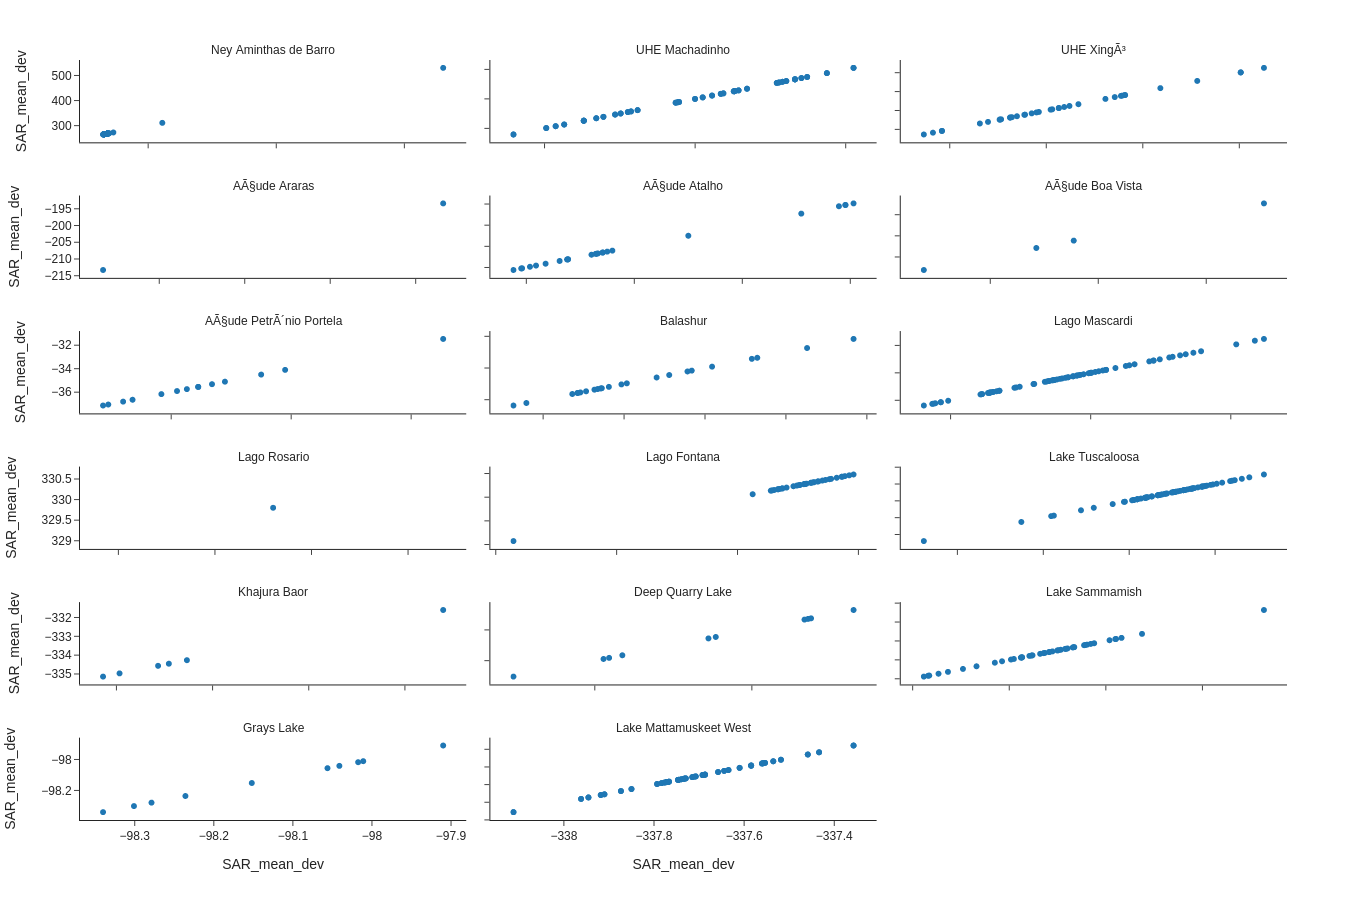

In [83]:
df=df_lake_final.copy()
df['SAR_mean_dev']=df['height_k_median']-df['height_k_median'].mean()
df['LRM_mean_dev']=df['height']-df['height'].mean()
x_fd='SAR_mean_dev'
y_fd='SAR_mean_dev'
facet='lake_name_k_first'
# color='height_count'
fig = px.scatter(df, x=x_fd, y=y_fd, 
                 facet_col=facet,facet_col_wrap=3,
                 template="simple_white", width=1200, height=900)
# fig.update_traces(marker=dict(size=5,color='#661666'))
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()
del df

In [ ]:
import pandas as pd
import os
# import geopandas as gpd
#test reading Karina's observations
#Pending to pass the code to full observations 


col_id_fd='lake_id'
# list_lakes=df_sel_lakes.loc[df_sel_lakes['source'].isin(['RVBR', 'LOCSS', 'ARNH', 'USGS']),col_id_fd].unique()
#TODO validate empty list
df_files_wlts=pd.DataFrame()
df_files_tfew=pd.DataFrame()
df_files_conv=pd.DataFrame()
sep=' '

for folder in os.listdir(path_to_ts):
        path=path_to_ts+folder+'/'
        files_wlts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))&f.startswith('wlts_')&(f.endswith('ocog.dat'))]
        files_conv = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))&f.startswith('conv_')&(f.endswith('ocog.dat'))]
        files_tfew = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))&f.startswith('tfew_')&(f.endswith('ocog.dat'))]
        
        sep=' '
        # Files with model reconstruction time series
        for f in files_wlts:
            f_name=path+f
            df_file=pd.read_csv(f_name, sep=sep)
            df_file['ts_type']=f[:4]
            df_file['sat']=f[5:8]
            df_file['orbit']=f[9:12]
            df_file['retracker']=f[13:17]
            df_file['lake_id']=folder
            df_file=df_file.rename(columns={'time\t':'time','wl\t':'wl'})
            df_files_wlts=pd.concat([df_files_wlts, df_file], axis=0)
            # print(df_files_wlts)
            # break
        sep=','
        # Files with results of modeling 
        for f in files_conv:
            f_name=path+f
            df_file=pd.read_csv(f_name, sep=sep)
            df_file['ts_type']=f[:4]
            df_file['sat']=f[5:8]
            df_file['orbit']=f[9:12]
            df_file['retracker']=f[13:17]
            df_file['lake_id']=folder
            df_files_conv=pd.concat([df_files_conv, df_file], axis=0)
            
        for f in files_tfew:
            f_name=path+f
            if os.stat(f_name).st_size != 0: 
                df_file=pd.read_csv(f_name)
                print('Not Empty', df_file)



In [ ]:
#Verify the error type Karina mentioned
#Read ground observations
#Create the match with the altimeter series
#Summarize error
#Compare with our approach
